In [1]:
from mcap_processing import open_files_in_folder, merge_dictionaries, convert_dict_to_pandas_df, get_start_end_times, get_all_msgs_from_mcap, get_important_data_for_times
from functools import reduce
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

# data loading
these function evals load the mcap data on your local machine for processing with the below blocks

In [2]:
def convert_dict_to_pandas_df_zero_aligned_seconds(all_msgs_dict: dict, last_end_time=None) -> pd.DataFrame:
    records = []
    evaluating_first_recorded_msg = True
    first_time = 0
    prev_log_time_ns = 0
    curr_diff = 0
    log_time = 0
    # logic flow:
    #     if we are the first mcap being accumulated in the list of mcaps, we set our start time to 0 and look at the difference in msg.log_time between 
    #     the previous msg.log_time and the current msg.log_time. This difference is accumulated and the current accumulated time is the new log_time.
    #      if we are not the first mcap being accumulated, our first time is the last_end_time (ns). 
    for topic, messages in all_msgs_dict.items():
        for msg in messages:
            if not evaluating_first_recorded_msg:
                curr_diff = (msg.log_time - prev_log_time_ns) + curr_diff
            
            if last_end_time is not None:
                log_time = curr_diff + last_end_time
            else:
                log_time = curr_diff
            record = {
                'topic': topic,
                'schema': msg.schema,
                'channel': msg.channel,
                'message': msg.message,
                'proto_msg': msg.proto_msg,
                'log_time': (float(log_time) / 1.0e9)
            }
            prev_log_time_ns = msg.log_time
            records.append(record)

    # Create the DataFrame
    df = pd.DataFrame(records)
    return df, log_time

## simple data loading (mostly single mcap file handling, preserves timestamp)

In [8]:
mcap_readers, files = open_files_in_folder("./mcaps/testing_multi_mcap")

msgs_total = {}
for reader in mcap_readers:
    msgs_total = merge_dictionaries(msgs_total, get_all_msgs_from_mcap(reader))
df = convert_dict_to_pandas_df(msgs_total)
important_times = get_start_end_times(df, "mcu_status_data", "ecu_state", "5")
cut_df = get_important_data_for_times(df, important_times)

/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_13_35_50.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_21_24_15.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_21_33_27.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_21_39_03.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_21_49_23.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_21_53_55.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_21_57_20.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_22_06_40.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_22_16_56.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_22_27_19.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_22_33_29.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_29_2023_22_37_53.mcap
/hom

KeyboardInterrupt: 

## advanced data loading (load all mcap files in a folder)

In [4]:
import concurrent.futures
import multiprocessing
from queue import Empty
import copy

def process_reader(reader, queue, errors):
    try:
        ret_dict = get_all_msgs_from_mcap(reader)
        queue.put(copy.deepcopy(ret_dict))
    except Exception as e:
        errors.append((reader, e))

mcap_readers, files = open_files_in_folder("./mcaps/testing_multi_mcap")
queue = multiprocessing.Queue()
errors = multiprocessing.Manager().list()

processes = []
for reader in mcap_readers:
    process = multiprocessing.Process(target=process_reader, args=(reader, queue, errors))
    processes.append(process)
    process.start()

for process in processes:
    process.join()

msgs_total = {}
while True:
    try:
        ret_dict = queue.get_nowait()
        print(len(ret_dict))
        msgs_total = merge_dictionaries(msgs_total, ret_dict)
    except Empty:
        break

all_msgs_df = convert_dict_to_pandas_df_zero_aligned_seconds(msgs_total)


/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_30_2023_00_11_23.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_30_2023_00_16_36.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_30_2023_00_30_15.mcap
/home/ben/hytech/mcap_analysis/./mcaps/testing_multi_mcap/07_30_2023_00_38_34.mcap


Process Process-10:
Traceback (most recent call last):
  File "/tmp/ipykernel_8187/3711323327.py", line 9, in process_reader
    queue.put(copy.deepcopy(ret_dict))
              ^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/copy.py", line 146, in deepcopy
    y = copier(x, memo)
        ^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/copy.py", line 231, in _deepcopy_dict
    y[deepcopy(key, memo)] = deepcopy(value, memo)
                             ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/copy.py", line 146, in deepcopy
    y = copier(x, memo)
        ^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/copy.py", line 206, in _deepcopy_list
    append(deepcopy(a, memo))
           ^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/copy.py", line 172, in deepcopy
    y = _reconstruct(x, memo, *rv)
        ^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/usr/lib64/python3.11/copy.py", line 271, in _reconstruct
    state = deepcopy(state, memo)
            ^^^^^^^^^^^^^^^^^^^^^
  File "/usr/li

In [17]:
print(queue)

AttributeError: 'Queue' object has no attribute 'size'

# plotting helper functions
TODO maybe move into local python lib?

In [1]:
# for some dataframe and message topic, plot the message member w.r.t log_time
def time_plot_msg_member(df, topic, pb_msg_member):
    msgs = df[df['topic'] == topic]
    msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_member)
    plt.show()

def time_plot_multi_msg_members(df, topic, pb_msg_members_list):
    msgs = df[df['topic'] == topic]
    plt.figure(figsize=(16, 8), dpi=150) 
    for pb_msg_member in pb_msg_members_list:
        msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    msgs.plot(x='log_time', y=pb_msg_members_list)
    plt.show()

def multi_topic_time_plot_multi_msg_members(df, topic_msg_member_list_dict):
    member_list = []
    msgs_to_plot = {}
    df_list = []
    for key, value in topic_msg_member_list_dict.items():
        member_list.extend(value[0])
        
        msgs = df[df['topic'] == key]
        for pb_msg_member in value[0]:
            
            msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
            normalize = value[1]
            if(normalize):
                msgs[pb_msg_member] = msgs[pb_msg_member] / msgs[pb_msg_member].abs().max()
        df_list.append(msgs)
    
    
    total_col_list = member_list + ['log_time']
    merged_df = df_list[0]
    for i in range(len(df_list) - 1 ):
        i=i+1
        print(merged_df.columns)
        merged_df = pd.merge_asof(merged_df, df_list[i], on='log_time', tolerance=pd.Timedelta('100ms'))
        merged_df = merged_df[merged_df.columns.intersection(total_col_list)]

    merged_df['time_diff'] = merged_df['log_time'] - merged_df['log_time'].iloc[0]

    # Convert the time difference to total seconds
    merged_df['Seconds'] = merged_df['time_diff'].dt.total_seconds()

    # print(merged_df)
    
    merged_df.plot(x='Seconds', y=member_list, figsize=(32,16))
    # plt.figure(figsize=(32, 16), dpi=150)
    plt.show()

# pandas dataframe processors helper functions
- `get_time_range_df` returns a dataframe containing only messages between the start and end epoch times (can be easily gotten from foxglove)

In [2]:
# gets a df that has messages between the start and end time of a df that has a single MCAP in it
def get_time_range_df(df, start_time_epoch_sec, end_time_epoch_sec):
    return df[(((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) >= start_time_epoch_sec) & ((((df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9) <= end_time_epoch_sec))]


def get_msg_df_with_added_member_column(all_msgs, topic, pb_msg_member):
    msgs = all_msgs[all_msgs['topic'] == topic]
    msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
    return msgs

def get_df_with_seconds_column(df):
    df['time_diff'] = df['log_time'] - df['log_time'].iloc[0]

    # Convert the time difference to total seconds
    df['seconds'] = df['time_diff'].dt.total_seconds()
    return df

# returns a dataframe with all of the requested msgs gotten from the dataframe and aligned at tolerance
def get_combined_df_with_all_msgs(df, msgs_dict, alignment_tolerance):
    merged_df_list = []
    for topic, msg_member_list in msgs_dict.items():
        for msg_name in msg_member_list:
            res_df = get_msg_df_with_added_member_column(df, topic, msg_name)
            res_df = res_df[res_df.columns.intersection([msg_name, 'log_time'])]
            merged_df_list.append(res_df)
        
    merged_df = merged_df_list[0]
    # Iterate through the remaining dataframes and merge them one by one
    for df in merged_df_list[1:]:
        merged_df = pd.merge_asof(merged_df, df, on='log_time', tolerance=pd.Timedelta(alignment_tolerance))

    merged_df['time_diff'] = merged_df['log_time'] - merged_df['log_time'].iloc[0]
    # Convert the time difference to total seconds
    merged_df['seconds'] = merged_df['time_diff'].dt.total_seconds()
    return merged_df.dropna()

def monitor_and_split(df, columns_to_monitor, time_column='seconds'):
    # Store initial values of the monitored columns
    initial_values = df[columns_to_monitor].iloc[0].copy()
    # List to store the derived DataFrames
    derived_dataframes = []
    # Start index for slicing DataFrame
    start_idx = 0
    
    # Iterate over the DataFrame rows
    for idx, row in df.iterrows():
        # Check if there is any change in the monitored columns
        if not row[columns_to_monitor].equals(initial_values):
            # If there's a change, slice the DataFrame from start index to current index
            derived_df = df.iloc[start_idx:idx].copy()
            # Reset the seconds column to start from zero
            if time_column in derived_df.columns:
                derived_df[time_column] -= derived_df[time_column].iloc[0]
            # Add the derived DataFrame to the list
            derived_dataframes.append(derived_df)
            # Update the initial values to the current row values
            initial_values = row[columns_to_monitor].copy()
            # Update the start index to current index
            start_idx = idx
    
    # Handle the last segment
    if start_idx < len(df):
        derived_df = df.iloc[start_idx:].copy()
        # Reset the seconds column to start from zero
        if time_column in derived_df.columns:
            derived_df[time_column] -= derived_df[time_column].iloc[0]
        derived_dataframes.append(derived_df)
    
    return derived_dataframes

# split a single df that has the messages into multiple based on detecting change. 
# re-aligns the dataframe as well with each dataframe's seconds column starting at zero
def get_split_df(df, monitor_diff_msgs_dict, alignment_tolerance):
    # first, get a df with all the msgs that we want to look at
    df = get_df_with_seconds_column(df)
    new_df = get_combined_df_with_all_msgs(df, monitor_diff_msgs_dict, alignment_tolerance)
    all_msg_names = []
    for topic, msg_member_list in msgs_dict.items():
        for msg_name in msg_member_list:
            all_msg_names.append(msg_name)
    return monitor_and_split(df, all_msg_names)
    
    
    

# evaluations (usage of the above functions)

### suspension plotting

Index(['topic', 'schema', 'channel', 'message', 'proto_msg', 'log_time',
       'potentiometer_fl', 'potentiometer_fr'],
      dtype='object')
Index(['log_time', 'potentiometer_fl', 'potentiometer_fr', 'potentiometer_rl',
       'potentiometer_rr'],
      dtype='object')
Index(['log_time', 'potentiometer_fl', 'potentiometer_fr', 'potentiometer_rl',
       'potentiometer_rr', 'brake_percent_float'],
      dtype='object')


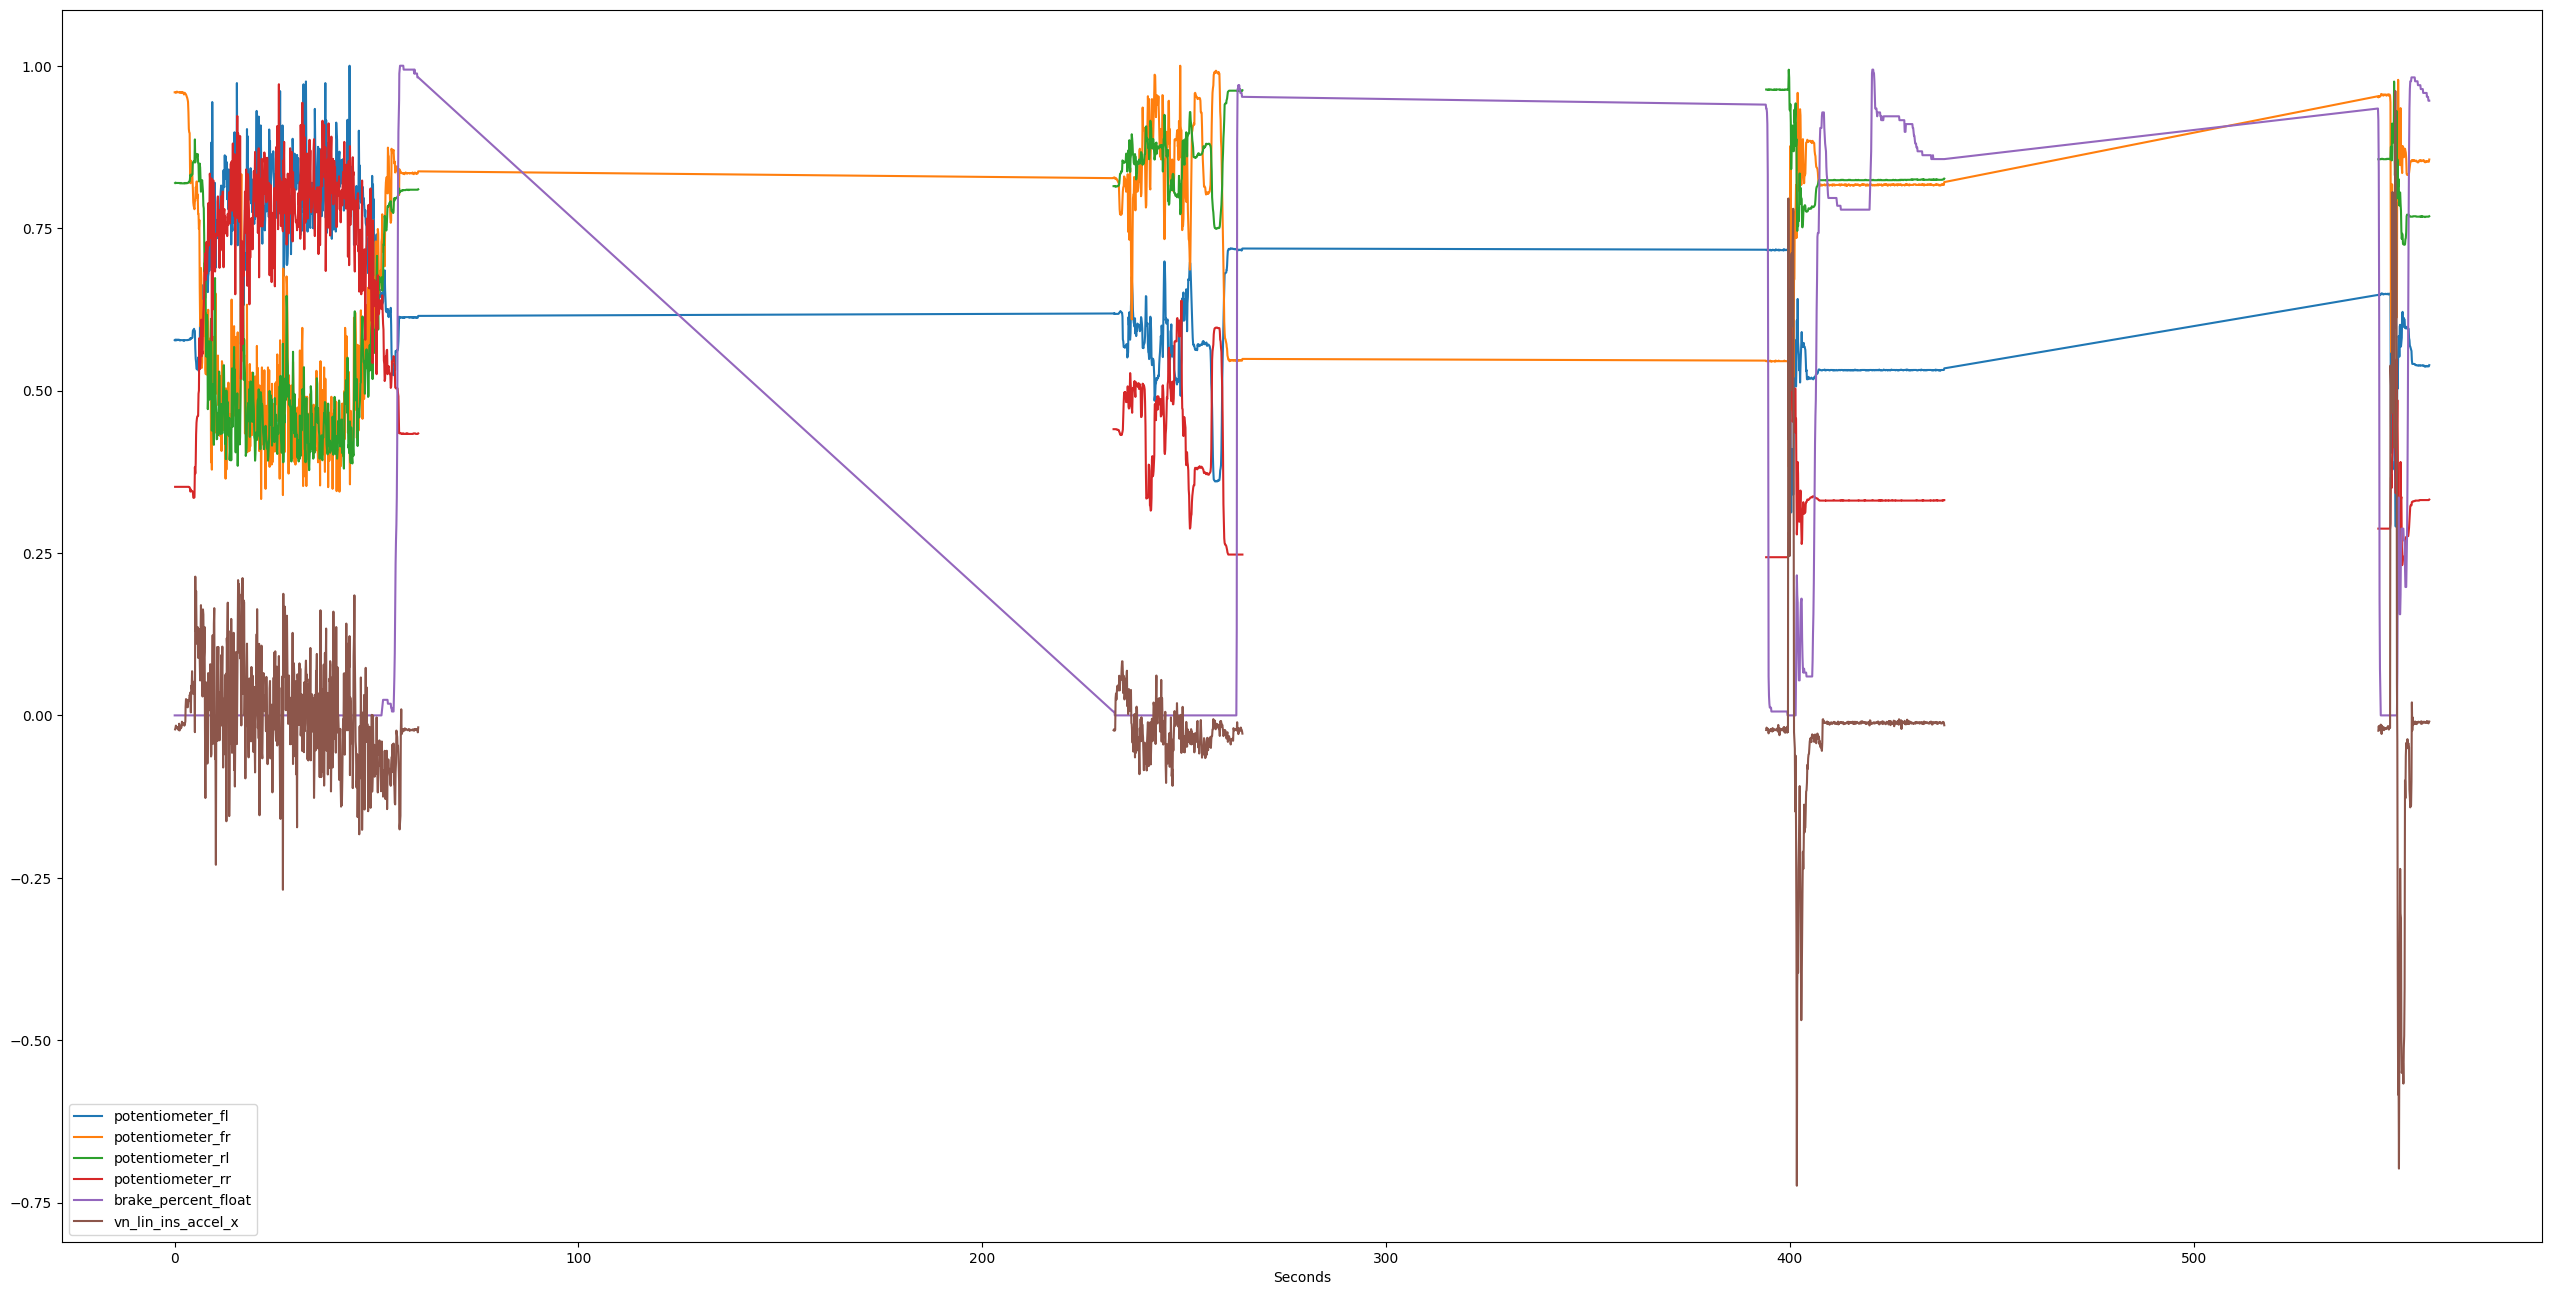

In [35]:
pd.options.mode.copy_on_write = True
def analyze_sus_pots(msgs_df):
    # time_plot_msg_member(msgs_df, 'mcu_suspension_data', 'potentiometer_fr')
    # time_plot_multi_msg_members(msgs_df, 'mcu_suspension_data', ['potentiometer_fl', 'potentiometer_fr'])
    msgs_dict = {
        "mcu_suspension_data": [['potentiometer_fl', 'potentiometer_fr'], True],
        "sab_suspension_data": [['potentiometer_rl', 'potentiometer_rr'], True],
        "mcu_pedal_readings_data": [['brake_percent_float'], True],
        "vn_linear_accel_data": [['vn_lin_ins_accel_x'], True]
    }
    multi_topic_time_plot_multi_msg_members(msgs_df, msgs_dict)

pd.set_option('float_format', '{:f}'.format)
# print( (((cut_df['log_time']- pd.Timestamp("1970-01-01")) // pd.Timedelta("1ns")) / 1e9))
# cut_df = get_time_range_df(cut_df, 1690560803.912279230,1690560860.036473048)
analyze_sus_pots(cut_df)


## getting total distance traveled in group of mcap files

In [25]:
pd.options.mode.copy_on_write = True
def get_total_distance_in_one_mcap_df(df):
    # getting only the vel msgs and log times
    velocity_msg_df = get_msg_df_with_added_member_column(df, 'vn_vel_data', 'vn_body_vel_x')
    velocity_msg_df = velocity_msg_df[velocity_msg_df.columns.intersection(['vn_body_vel_x', 'log_time'])]
    # getting only the status msgs and log times
    status_msg_df = get_msg_df_with_added_member_column(df, 'vn_status_data', 'vn_gps_status')
    status_msg_df = status_msg_df[status_msg_df.columns.intersection(['vn_gps_status', 'log_time'])]
    
    merged_df = pd.merge_asof(status_msg_df, velocity_msg_df, on='log_time', tolerance=pd.Timedelta('100ms'))
    test = (merged_df['vn_gps_status'].isin(['1', '2']))
    merged_df = merged_df[test].dropna()
    merged_df['time_delta'] = merged_df['log_time'].diff().dt.total_seconds()
    merged_df['time_delta'] = merged_df['time_delta'].fillna(0)
    merged_df['distance'] = merged_df['vn_body_vel_x'] * merged_df['time_delta']
    total_distance = merged_df['distance'].sum()
    return total_distance

print('total distance traveled in m: ', get_total_distance_in_one_mcap_df(cut_df))

total distance traveled in m:  2667.268277086768


/tmp/ipykernel_13397/534573033.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))
/tmp/ipykernel_13397/534573033.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  msgs[pb_msg_member] = msgs['proto_msg'].apply(lambda x: getattr(x, pb_msg_member))


# Controller Evaluation

## yaw pid performance correlation with yaw PID p

yaw pid error sum (over entire dataframe):  246.40119968354702
yaw pid error / s while moving over  1.0  m/s:  2.977073509544444
average yaw pid error while moving over  1.0  m/s:  0.19633561727772672


<Axes: xlabel='seconds'>

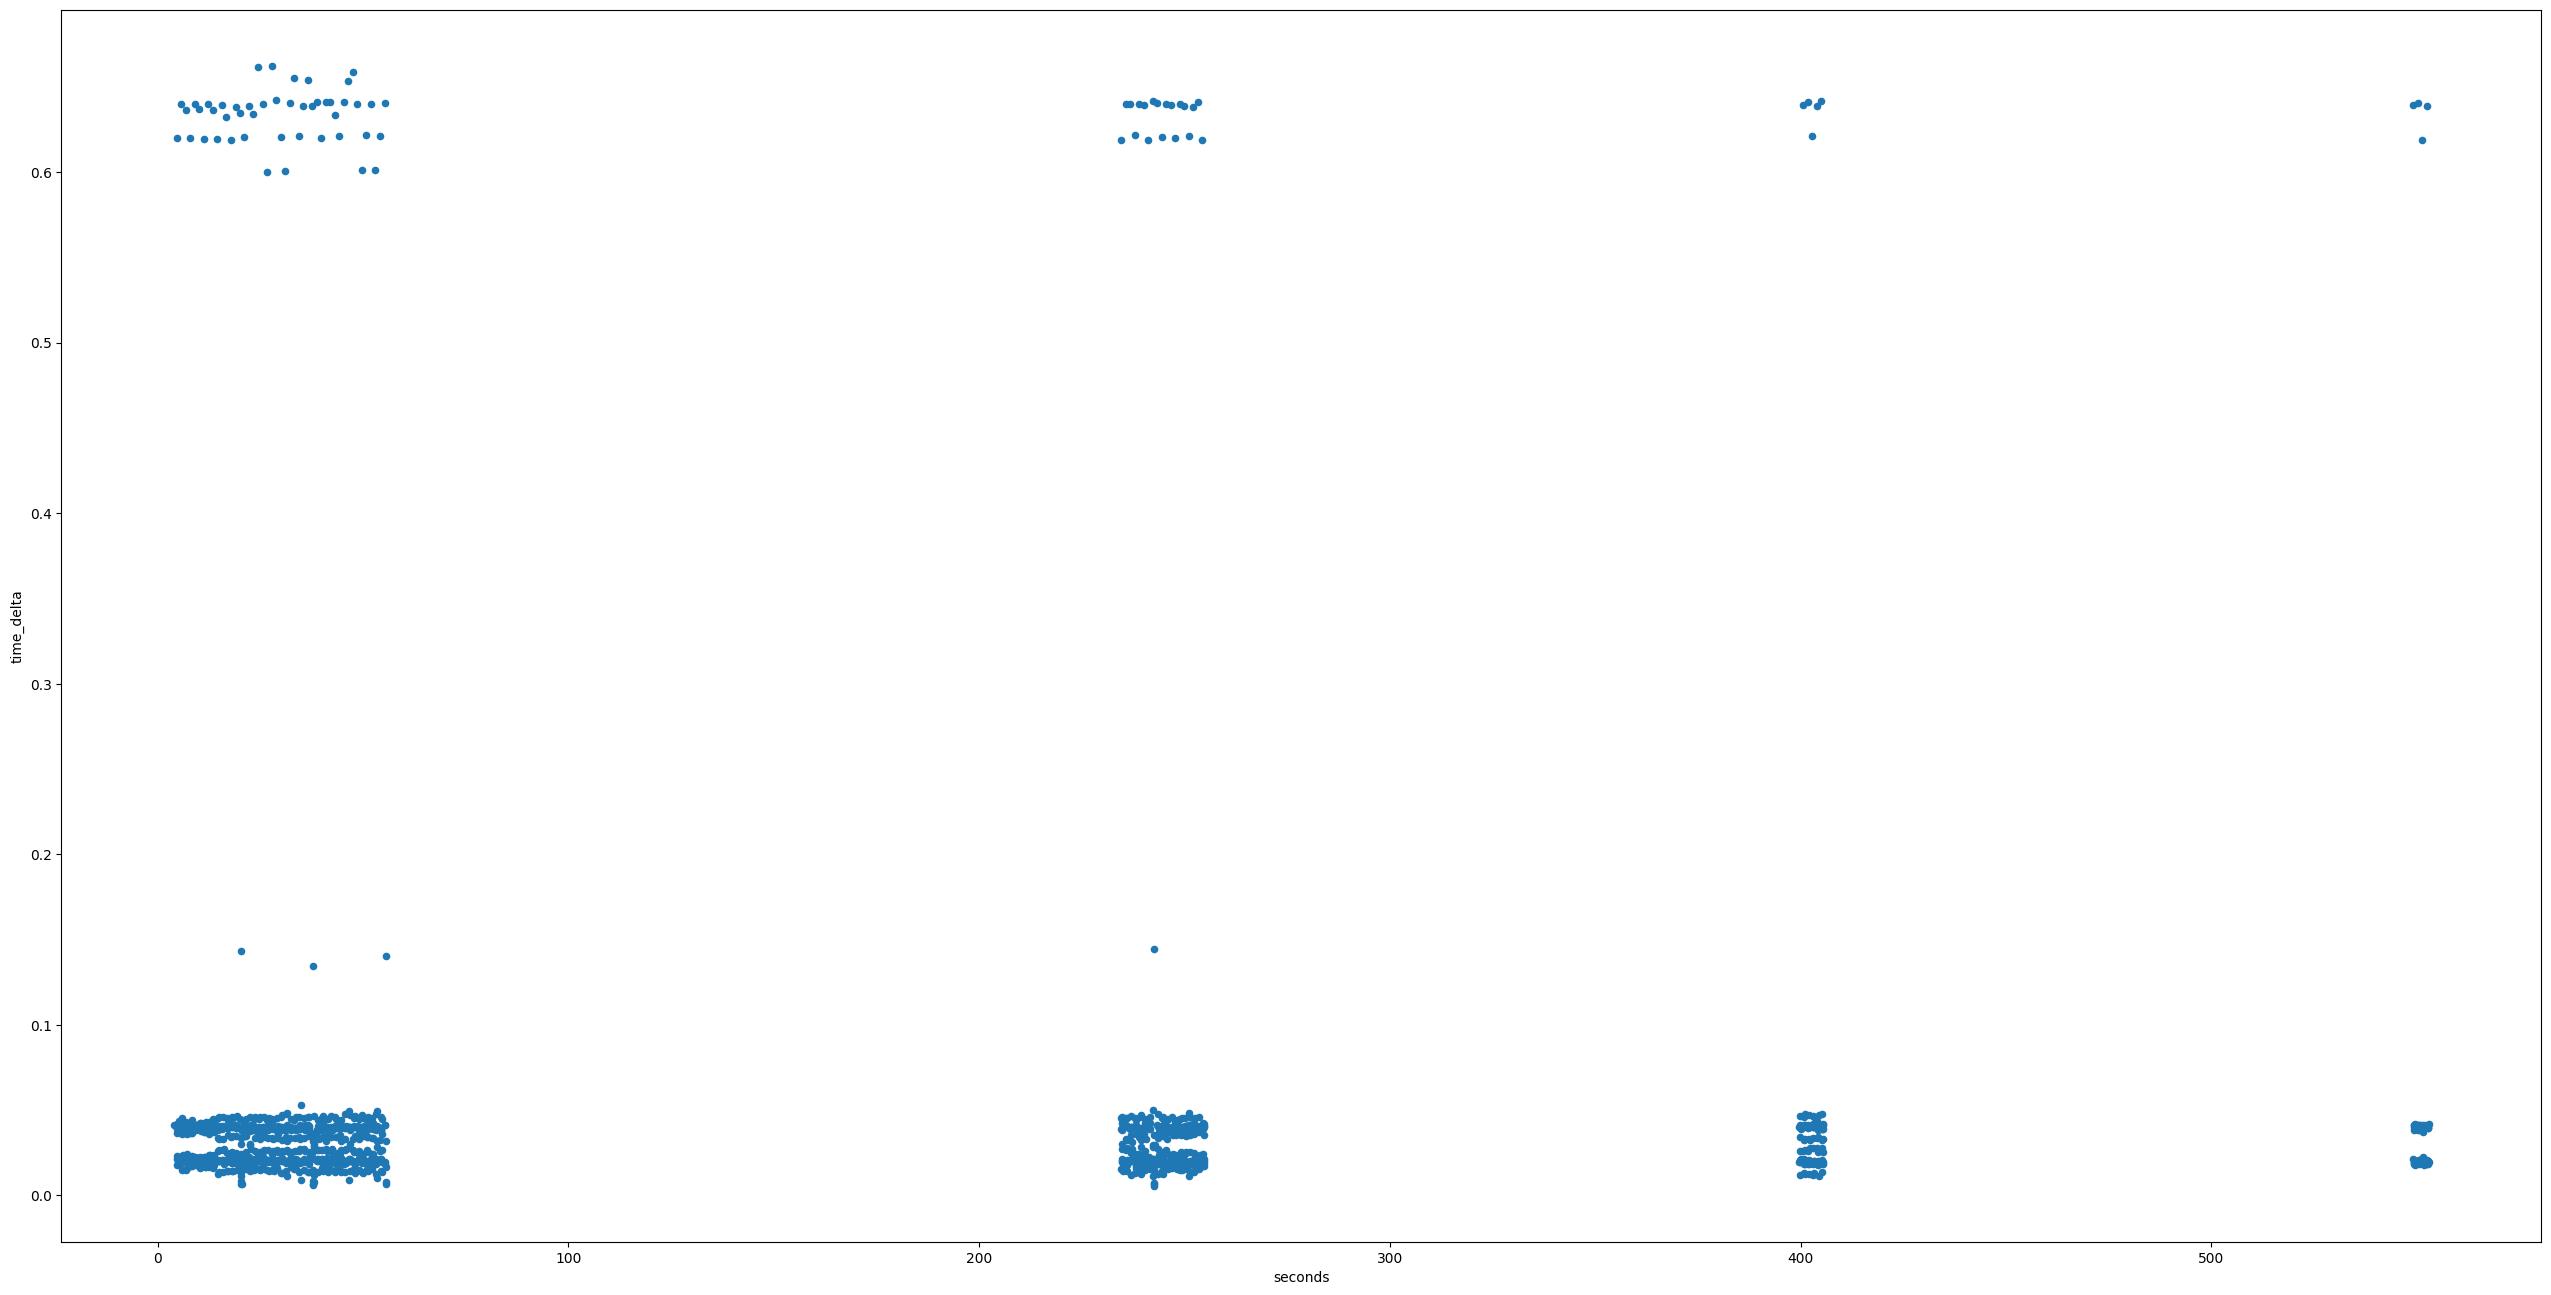

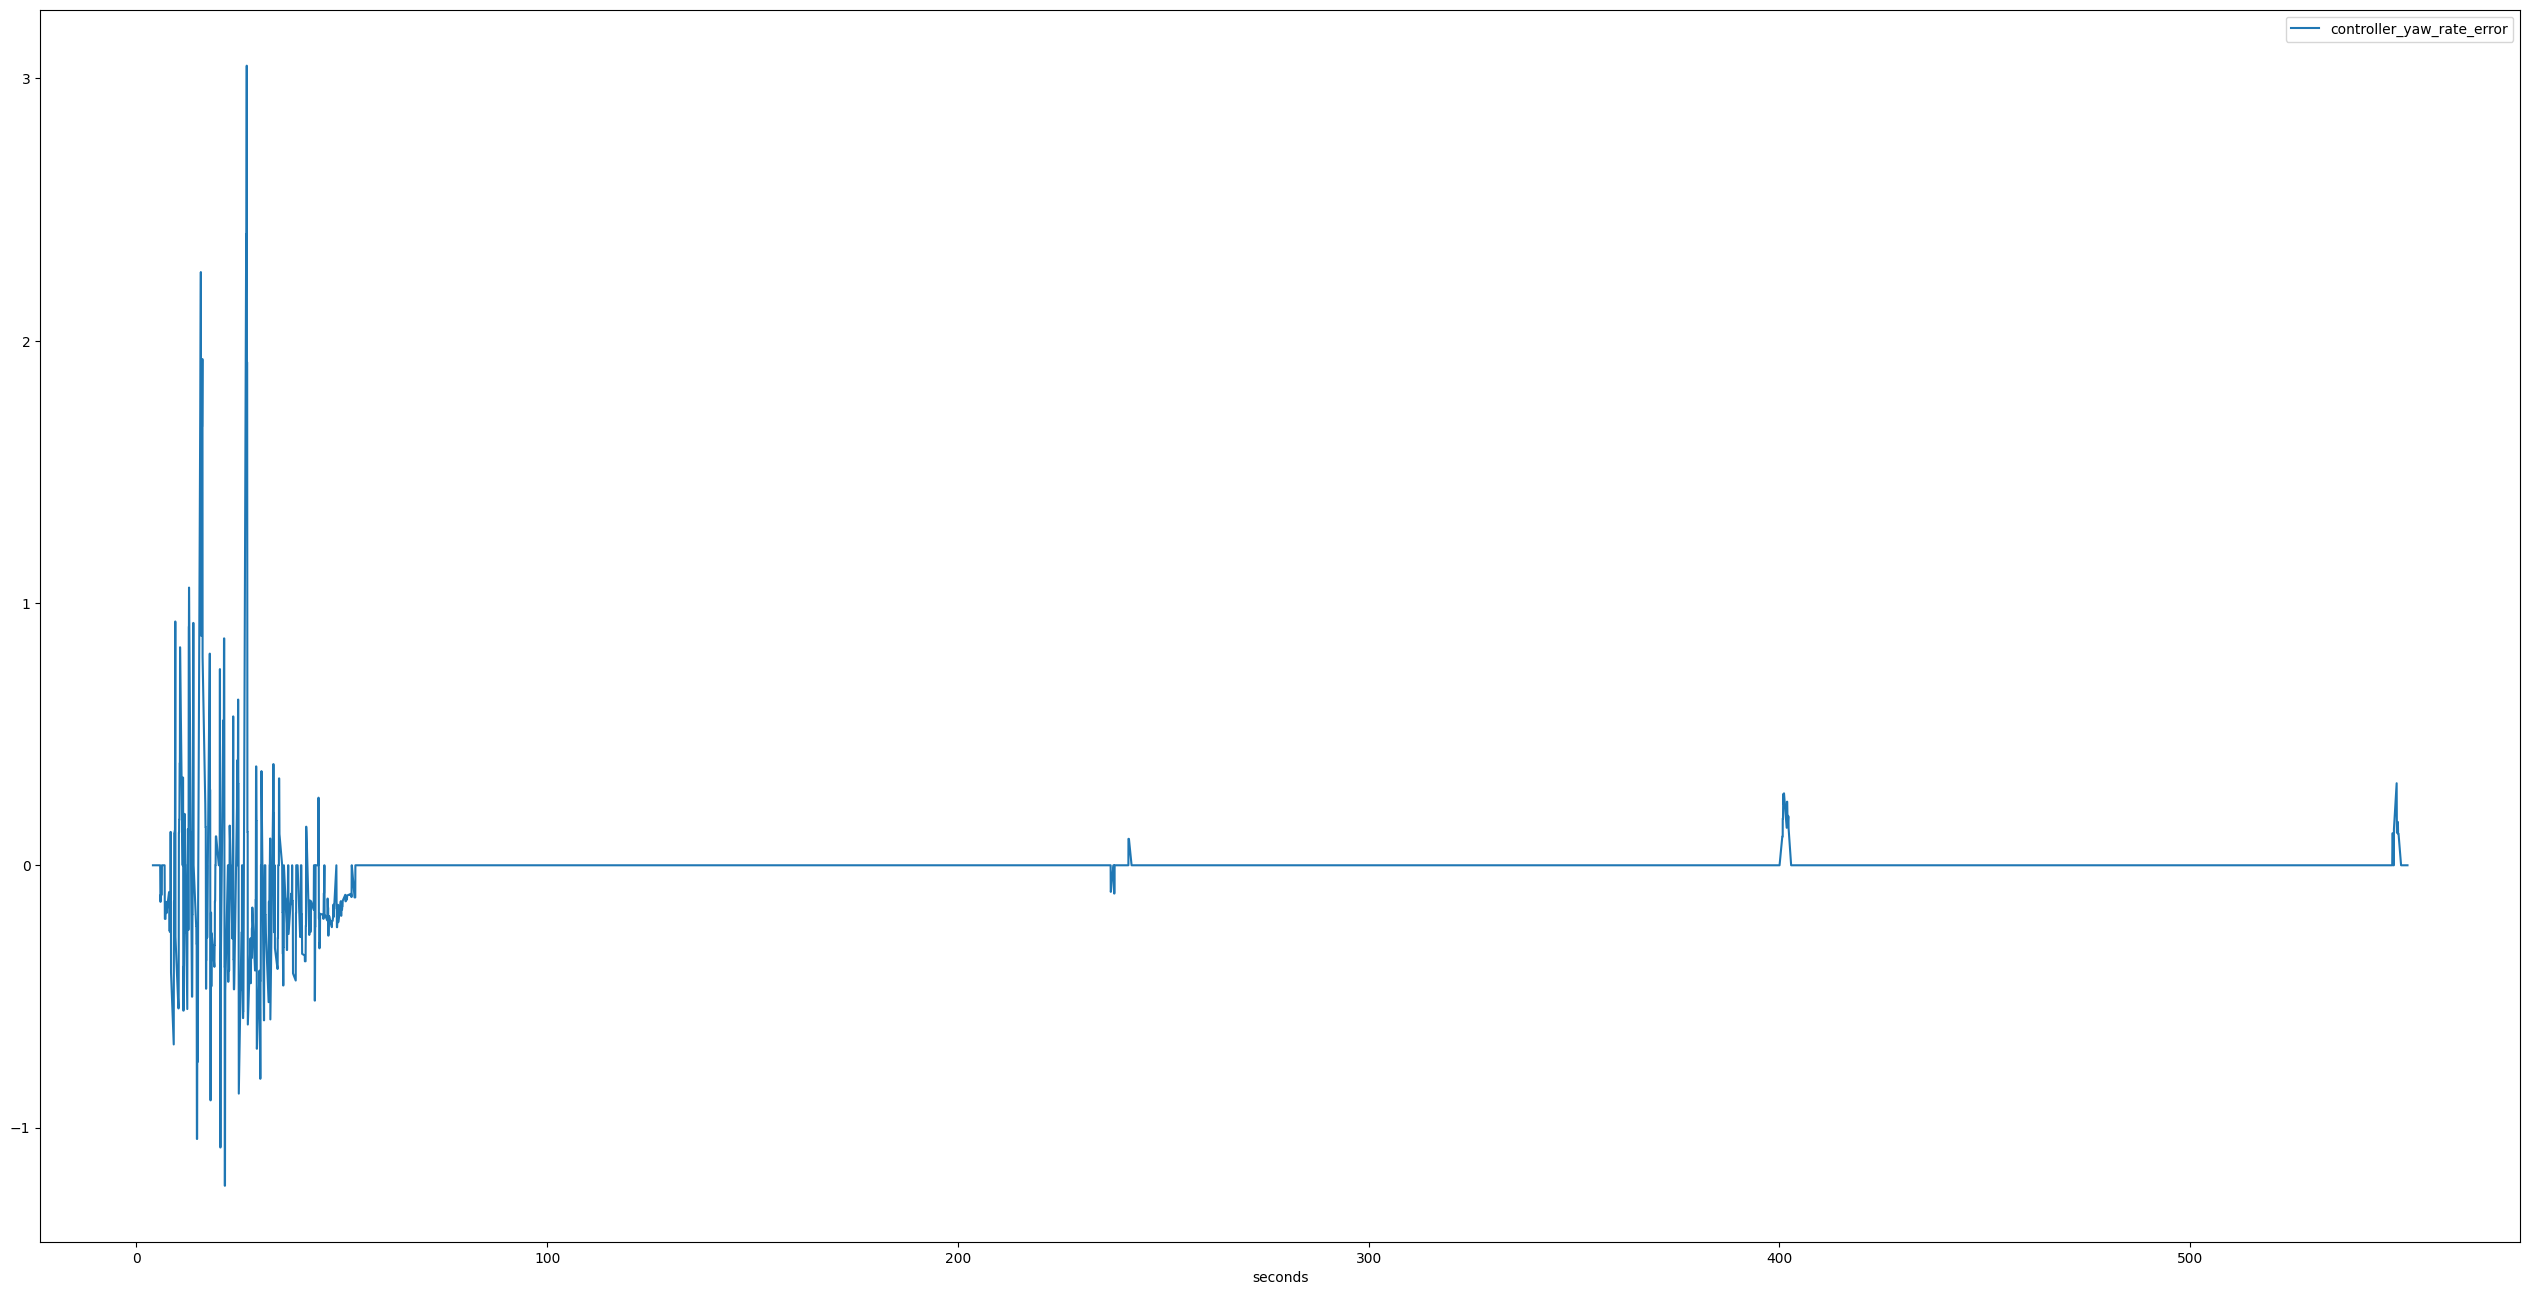

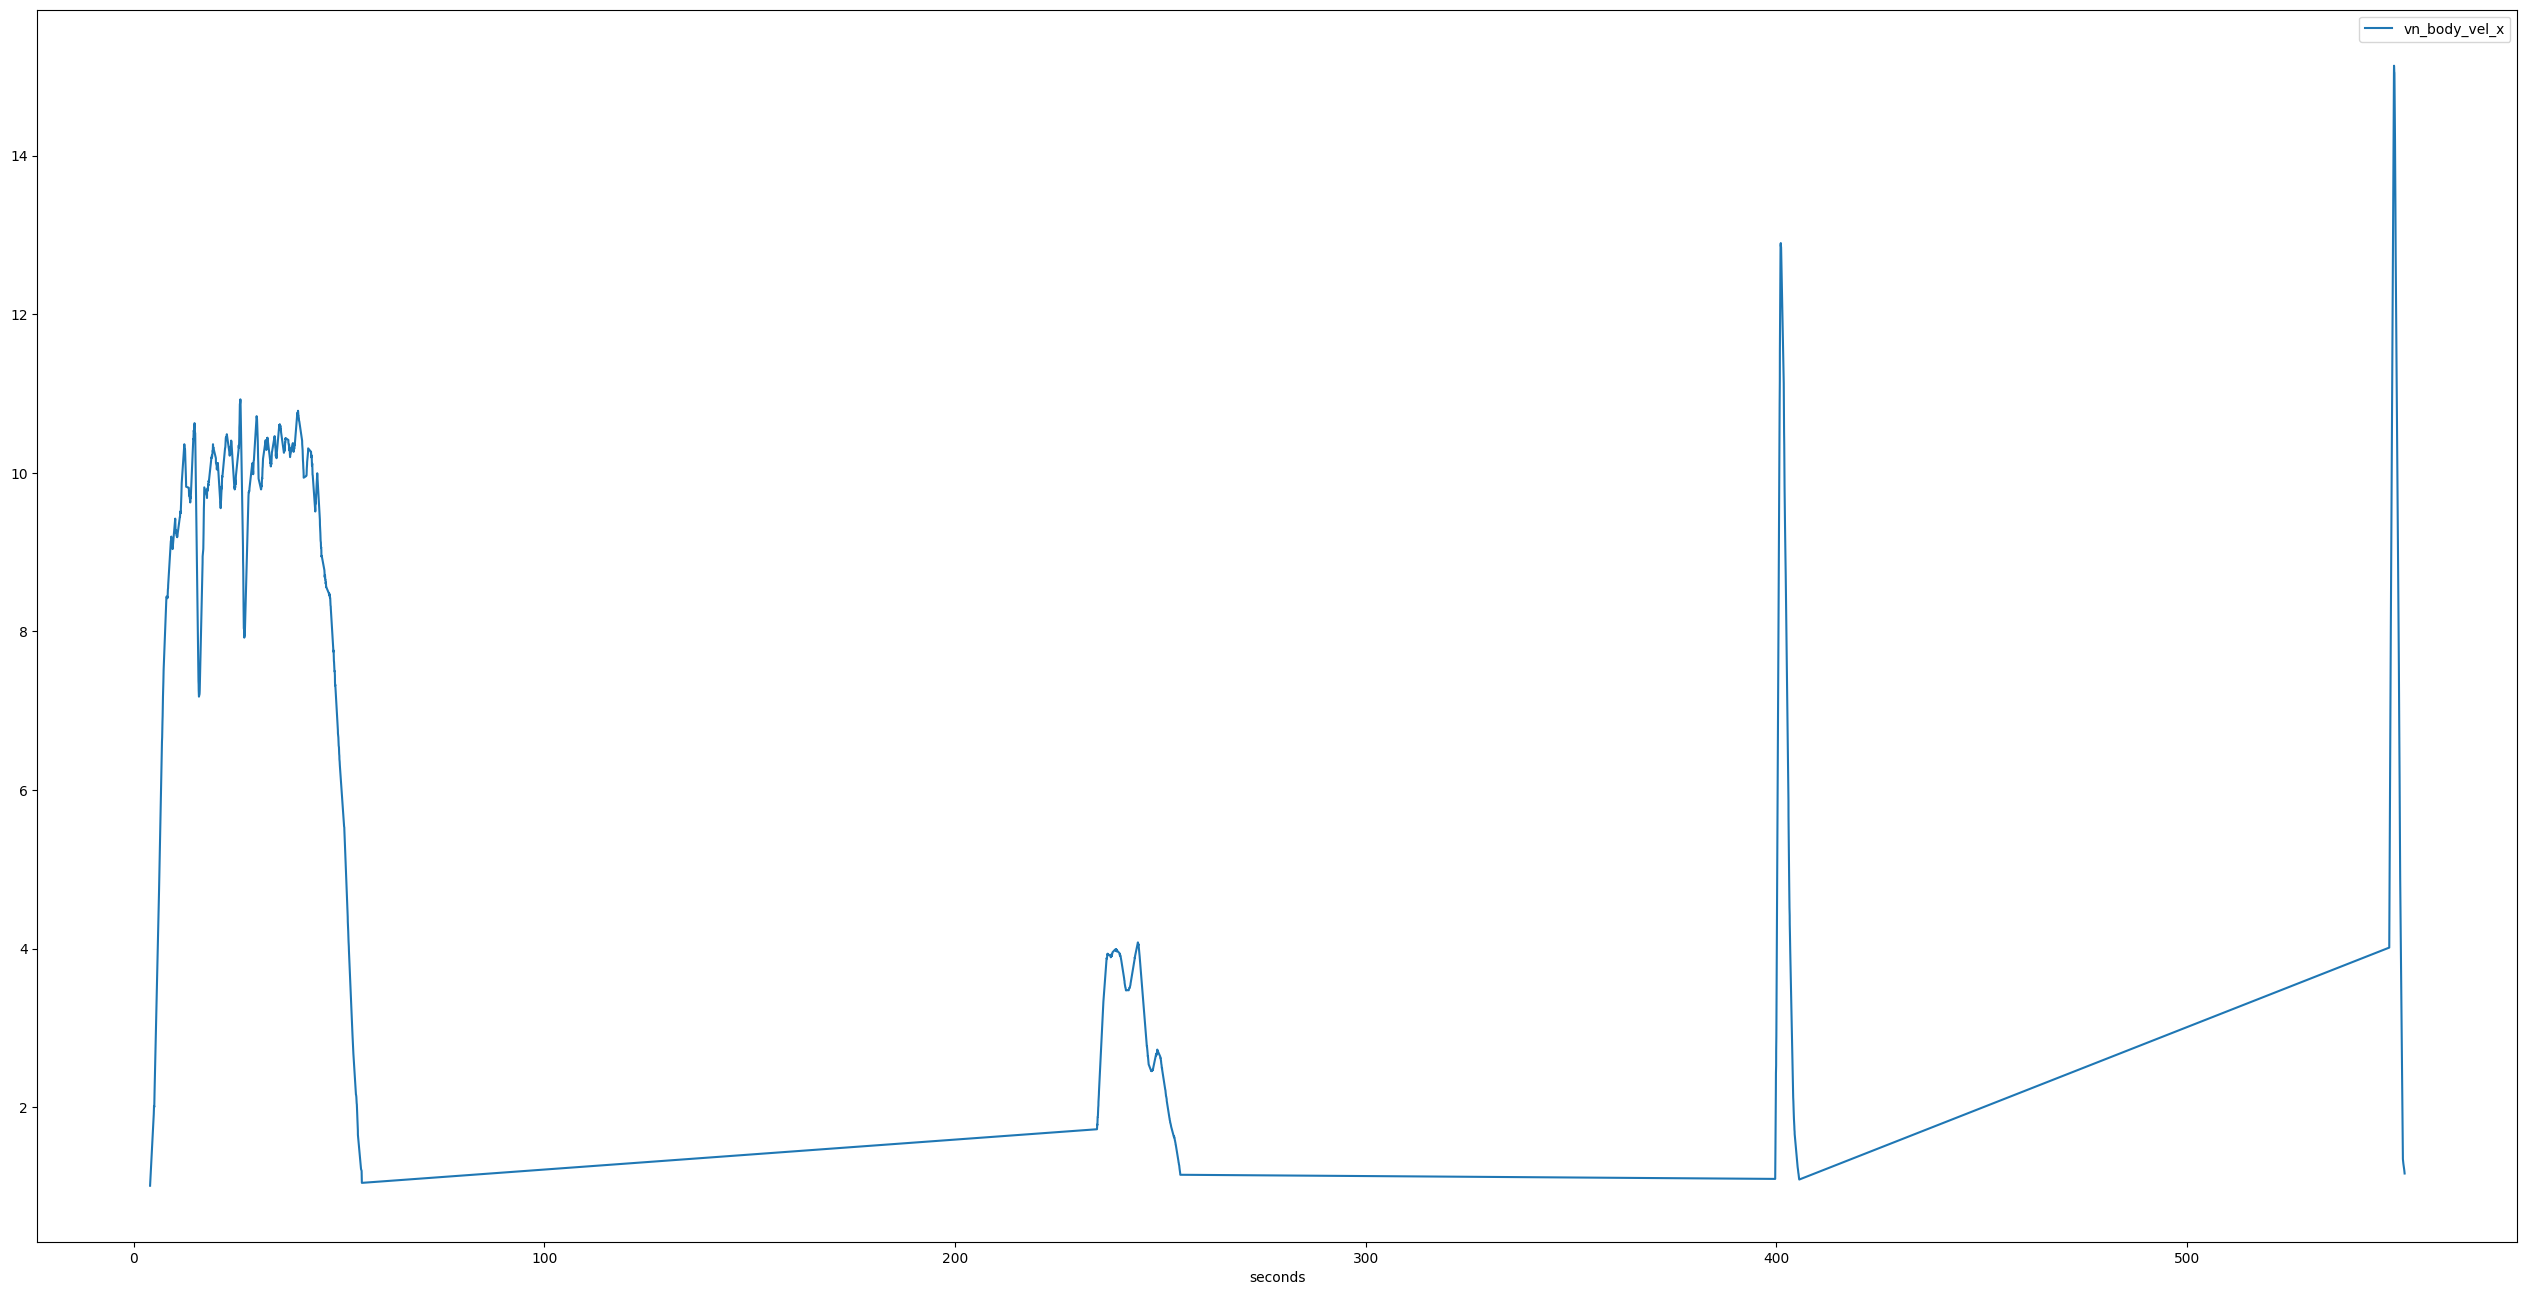

In [80]:
pd.options.mode.copy_on_write = True

msgs_dict = {
    'vn_angular_rate_data': ['angular_rate_z'],
    'vn_vel_data': ['vn_body_vel_x'],
    "controller_yaw_pid_config_data": ["controller_yaw_pid_p"],
    'controller_pid_yaw_data': ['controller_yaw_rate_error'],
    "mcu_status_data": ['drive_mode'],
    'vehm_kin_desired_yaw_rate_rad_s_data': ['vehm_kin_desired_yaw_rate_rad_s']
}

controller_eval_msgs_df = get_combined_df_with_all_msgs(cut_df, msgs_dict, '500ms')
controller_eval_msgs_df['time_delta'] = controller_eval_msgs_df['seconds'].diff()

controller_eval_msgs_df['time_delta'] = controller_eval_msgs_df['time_delta'].dropna()
controller_eval_msgs_df = controller_eval_msgs_df[controller_eval_msgs_df['time_delta'] <= 1]

controller_eval_msgs_df = controller_eval_msgs_df[controller_eval_msgs_df['drive_mode'] == 6]
speed_thresh = 1.0
controller_eval_msgs_df = controller_eval_msgs_df[controller_eval_msgs_df['vn_body_vel_x'] >= speed_thresh]

pid_err_sum = controller_eval_msgs_df['controller_yaw_rate_error'].abs().sum()
print('yaw pid error sum (over entire dataframe): ', pid_err_sum)

# getting the average error over the total time that we were moving during the log
average_pid_err_while_moving = pid_err_sum / controller_eval_msgs_df['time_delta'].sum()
print('yaw pid error / s while moving over ', speed_thresh, ' m/s: ', average_pid_err_while_moving)

# print(len(controller_eval_msgs_df['controller_yaw_rate_error']))
pid_err_average = controller_eval_msgs_df['controller_yaw_rate_error'].abs().sum() / len(controller_eval_msgs_df['controller_yaw_rate_error'])
print('average yaw pid error while moving over ', speed_thresh, ' m/s: ', pid_err_average)

controller_eval_msgs_df.plot.scatter(x='seconds', y='time_delta', figsize=(32,16))
controller_eval_msgs_df.plot(x='seconds', y='controller_yaw_rate_error', figsize=(32,16))
controller_eval_msgs_df.plot(x='seconds', y='vn_body_vel_x', figsize=(32,16))